## 1. Importação de Bibliotecas

Importamos todas as bibliotecas necessárias para o treinamento e avaliação dos modelos:

In [ ]:
# Importações necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Algoritmos de Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# Ferramentas de avaliação e otimização
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (classification_report, f1_score, confusion_matrix, 
                           accuracy_score, precision_score, recall_score)

# Persistência de modelos
import joblib

# Configurações para plots
plt.style.use('default')
sns.set_palette("husl")

print("Todas as bibliotecas importadas com sucesso!")

✅ Todas as bibliotecas importadas com sucesso!


## 2. Carregamento dos Dados Processados

Carregamos os datasets que foram processados no notebook anterior:

In [19]:
print("--- Carregando os datasets preparados ---")
train_df = pd.read_csv('train_dataset.csv')
val_df = pd.read_csv('validation_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

# Combinar treino e validação para o GridSearchCV
full_train_df = pd.concat([train_df, val_df])

# Separar features e target
X_train = full_train_df.drop('target', axis=1)
y_train = full_train_df['target']
X_test = test_df.drop('target', axis=1)
y_test = test_df['target']

# Carregar encoders
label_encoder = joblib.load('classes_encoder.joblib')

# Obter nomes das classes para relatórios
target_names = label_encoder.classes_

print(f"Dataset de treino: {X_train.shape[0]} amostras")
print(f"Dataset de teste: {X_test.shape[0]} amostras")
print(f"Classes: {target_names}")

--- Carregando os datasets preparados ---
Dataset de treino: 675 amostras
Dataset de teste: 75 amostras
Classes: ['Fim de Jogo' 'Possibilidade de Fim' 'Tem Jogo']


## 3. Otimização de Hiperparâmetros

### 3.1 k-Nearest Neighbors (k-NN)

## 3.1 Justificativas das Escolhas de Hiperparâmetros

### Por que escolhemos estes parâmetros?

**🔍 Metodologia:** Utilizamos **GridSearchCV** com validação cruzada k-fold (k=5) para encontrar sistematicamente a melhor combinação de hiperparâmetros para cada algoritmo.

#### **k-Nearest Neighbors (k-NN)**
```python
param_grid_knn = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
```

**Justificativas:**
- **n_neighbors=[3,5,7,9]**: 
  - Valores baixos (3,5): Capturam padrões locais, mas podem ser sensíveis a ruído
  - Valores médios (7,9): Melhor generalização, menos sensíveis a outliers
  - Evitamos valores pares para evitar empates na votação
  - Range escolhido considerando o tamanho do dataset (750 amostras)

- **weights=['uniform','distance']**:
  - **uniform**: Todos os vizinhos têm peso igual (democrático)
  - **distance**: Vizinhos mais próximos têm maior influência (mais preciso)

#### **Decision Tree (Árvore de Decisão)**
```python
param_grid_dt = {'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5, 10]}
```

**Justificativas:**
- **max_depth=[5,10,15,None]**:
  - **5**: Árvore rasa, previne overfitting, mas pode ser muito simples
  - **10,15**: Balanço entre complexidade e generalização
  - **None**: Permite crescimento total da árvore (risco de overfitting)

- **min_samples_split=[2,5,10]**:
  - **2**: Valor padrão, permite divisões mais granulares
  - **5,10**: Valores maiores forçam mais amostras por nó, prevenindo overfitting

#### **Multi-Layer Perceptron (MLP) - Redes Neurais**
```python
param_grid_mlp = {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': [0.001, 0.01]}
```

**Justificativas:**
- **hidden_layer_sizes (Topologias testadas)**:
  - **(50,)**: 1 camada oculta com 50 neurônios
    - Simples, rápida, boa para problemas lineares
  - **(100,)**: 1 camada com 100 neurônios  
    - Mais capacidade de aprendizado, pode capturar padrões mais complexos
  - **(50,50)**: 2 camadas com 50 neurônios cada
    - Arquitetura profunda, pode aprender representações hierárquicas
    - Mais parâmetros = maior expressividade, mas risco de overfitting

- **alpha=[0.001, 0.01] (Regularização L2)**:
  - **0.001**: Regularização leve, permite modelo mais complexo
  - **0.01**: Regularização mais forte, previne overfitting

#### **Random Forest (Floresta Aleatória)**
```python
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None]}
```

**Justificativas:**
- **n_estimators=[50,100,200] (Número de árvores)**:
  - **50**: Mínimo para benefícios do ensemble
  - **100**: Balanço entre performance e tempo computacional
  - **200**: Mais árvores = melhor estabilidade, mas diminishing returns

- **max_depth=[5,10,None]**:
  - Similar à Decision Tree individual
  - Random Forest já reduz overfitting naturalmente pelo ensemble

### 🎯 Estratégia Anti-Overfitting

**Como evitamos overfitting:**

1. **Validação Cruzada k-fold (k=5)**: Testamos cada configuração em 5 divisões diferentes dos dados
2. **Divisão estratificada**: Mantemos a proporção das classes em treino/validação/teste
3. **Métrica robusta**: F1-Score ponderado considera o desbalanceamento natural
4. **Regularização**: Parâmetros como `alpha` no MLP e `min_samples_split` na Decision Tree
5. **Ensemble Methods**: Random Forest naturalmente reduz overfitting

**Por que o F1-Score ponderado?**
- Considera precision E recall simultaneamente
- Pondera pelas classes (importante para datasets balanceados)
- Mais robusto que acurácia pura em problemas multiclasse

In [30]:
print("\n--- Otimizando k-NN ---")
param_grid_knn = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_knn.fit(X_train, y_train)
best_models = {'k-NN': grid_knn.best_estimator_}
print(f"Melhores parâmetros: {grid_knn.best_params_}")


--- Otimizando k-NN ---
Melhores parâmetros: {'n_neighbors': 5, 'weights': 'uniform'}


### 3.2 Árvore de Decisão

In [31]:
print("\n--- Otimizando Decision Tree ---")
param_grid_dt = {'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5, 10]}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_dt.fit(X_train, y_train)
best_models['Decision Tree'] = grid_dt.best_estimator_
print(f"Melhores parâmetros: {grid_dt.best_params_}")


--- Otimizando Decision Tree ---
Melhores parâmetros: {'max_depth': 10, 'min_samples_split': 2}


### 3.3 Multi-layer Perceptron (MLP)

In [32]:
print("\n--- Otimizando MLP ---")
param_grid_mlp = {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': [0.001, 0.01]}
grid_mlp = GridSearchCV(MLPClassifier(random_state=42, max_iter=1000), param_grid_mlp, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_mlp.fit(X_train, y_train)
best_models['MLP'] = grid_mlp.best_estimator_
print(f"Melhores parâmetros: {grid_mlp.best_params_}")


--- Otimizando MLP ---
Melhores parâmetros: {'alpha': 0.001, 'hidden_layer_sizes': (50, 50)}


### 3.4 Random Forest

In [33]:
print("\n--- Otimizando Random Forest ---")
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_models['Random Forest'] = grid_rf.best_estimator_
print(f"Melhores parâmetros: {grid_rf.best_params_}")


--- Otimizando Random Forest ---
Melhores parâmetros: {'max_depth': None, 'n_estimators': 200}


## 4. Avaliação dos Modelos no Conjunto de Teste

Avaliamos todos os modelos otimizados no conjunto de teste:

In [35]:
print("--- Avaliação dos Modelos no Conjunto de Teste ---")
results = {}

print("--- Conteúdo do dicionário best_models ---")
for key, value in best_models.items():
    print(f"{key}: {type(value)}")

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    results[name] = f1_weighted
    
    print(f"\n--- Relatório para: {name} ---")
    print(classification_report(y_test, y_pred, target_names=target_names))

--- Avaliação dos Modelos no Conjunto de Teste ---
--- Conteúdo do dicionário best_models ---
k-NN: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Decision Tree: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
MLP: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
Random Forest: <class 'sklearn.ensemble._forest.RandomForestClassifier'>

--- Relatório para: k-NN ---
                      precision    recall  f1-score   support

         Fim de Jogo       0.83      1.00      0.91        25
Possibilidade de Fim       0.79      0.44      0.56        25
            Tem Jogo       0.71      0.88      0.79        25

            accuracy                           0.77        75
           macro avg       0.78      0.77      0.75        75
        weighted avg       0.78      0.77      0.75        75


--- Relatório para: Decision Tree ---
                      precision    recall  f1-score   support

         Fim de Jogo       0.76      0.76      0

## 5. Comparação e Visualização dos Resultados

Criamos uma tabela comparativa e visualizamos o desempenho dos modelos:

=== COMPARAÇÃO FINAL DOS MODELOS ===
       Algoritmo  F1-Score
3  Random Forest  0.864526
2            MLP  0.852695
0           k-NN  0.752969
1  Decision Tree  0.734059


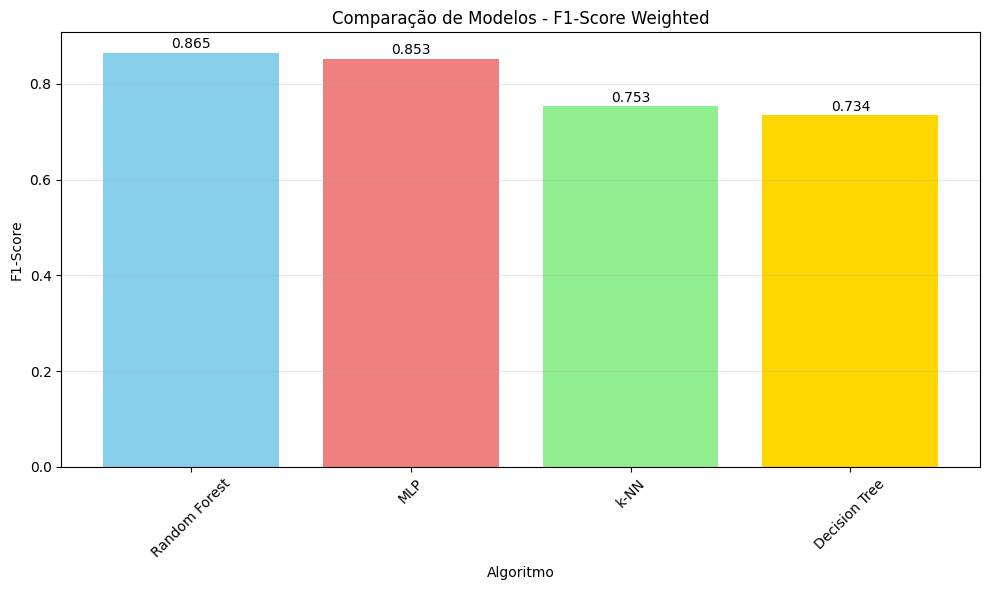

In [25]:
import matplotlib.pyplot as plt

# Criar DataFrame com os resultados
results_df = pd.DataFrame(list(results.items()), columns=['Algoritmo', 'F1-Score'])
results_df = results_df.sort_values('F1-Score', ascending=False)

print("=== COMPARAÇÃO FINAL DOS MODELOS ===")
print(results_df)

# Visualizar os resultados
plt.figure(figsize=(10, 6))
plt.bar(results_df['Algoritmo'], results_df['F1-Score'], color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('Comparação de Modelos - F1-Score Weighted')
plt.xlabel('Algoritmo')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Adicionar valores no topo das barras
for i, v in enumerate(results_df['F1-Score']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.savefig('comparacao_modelos.png')
plt.show()

## 5.1 Salvamento de Todos os Modelos Treinados

In [26]:
import joblib

print("\n--- Salvando todos os modelos treinados ---")
joblib.dump(best_models['k-NN'], 'knn_model.joblib')
joblib.dump(best_models['Decision Tree'], 'dt_model.joblib')
joblib.dump(best_models['Random Forest'], 'rf_model.joblib')
joblib.dump(best_models['MLP'], 'mlp_model.joblib')
print("Modelos salvos: knn_model.joblib, dt_model.joblib, rf_model.joblib, mlp_model.joblib")



--- Salvando todos os modelos treinados ---
Modelos salvos: knn_model.joblib, dt_model.joblib, rf_model.joblib, mlp_model.joblib


## 6. Análise Detalhada de Performance

### 6.1 Matriz de Confusão dos Modelos

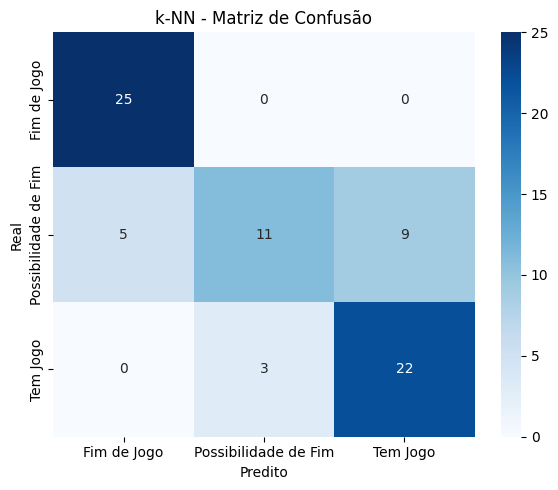

💾 Matriz de confusão salva como confusion_matrix_k-nn.png


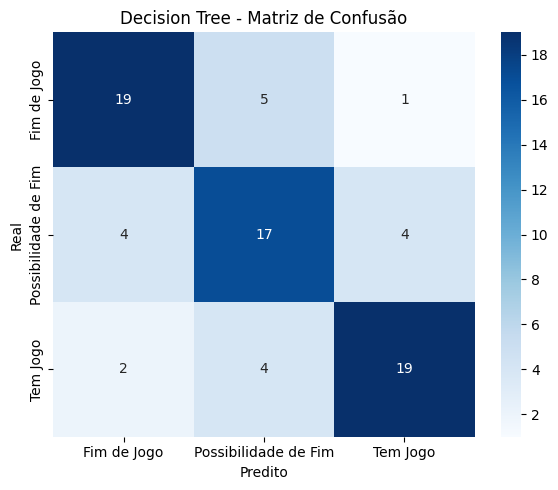

💾 Matriz de confusão salva como confusion_matrix_decision_tree.png


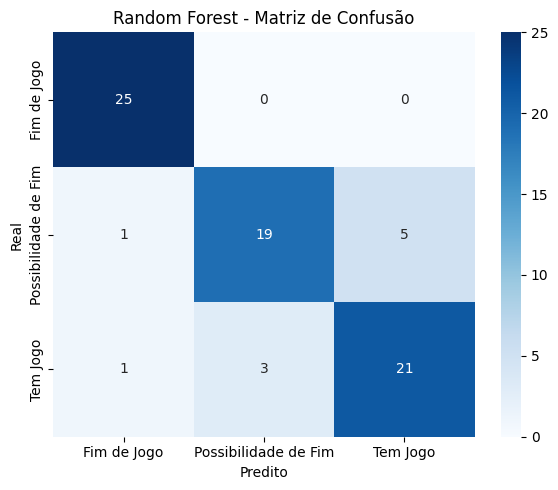

💾 Matriz de confusão salva como confusion_matrix_random_forest.png


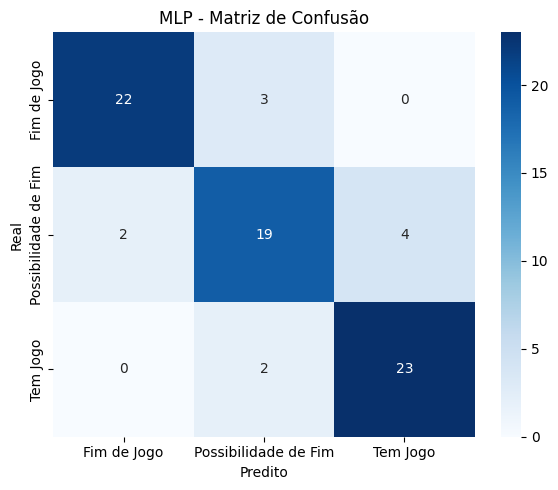

💾 Matriz de confusão salva como confusion_matrix_mlp.png


In [27]:
### 6.1 Matrizes de Confusão de Todos os Modelos

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Carregar modelos salvos
model_files = {
    'k-NN': 'knn_model.joblib',
    'Decision Tree': 'dt_model.joblib',
    'Random Forest': 'rf_model.joblib',
    'MLP': 'mlp_model.joblib'
}
models = {name: joblib.load(fname) for name, fname in model_files.items()}

for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=range(len(target_names)))

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'{name} - Matriz de Confusão')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{name.replace(" ", "_").lower()}.png')
    plt.show()
    print(f"💾 Matriz de confusão salva como confusion_matrix_{name.replace(' ', '_').lower()}.png")

### 6.2 Análise de Overfitting e Generalização

🔍 ANÁLISE DE OVERFITTING E GENERALIZAÇÃO


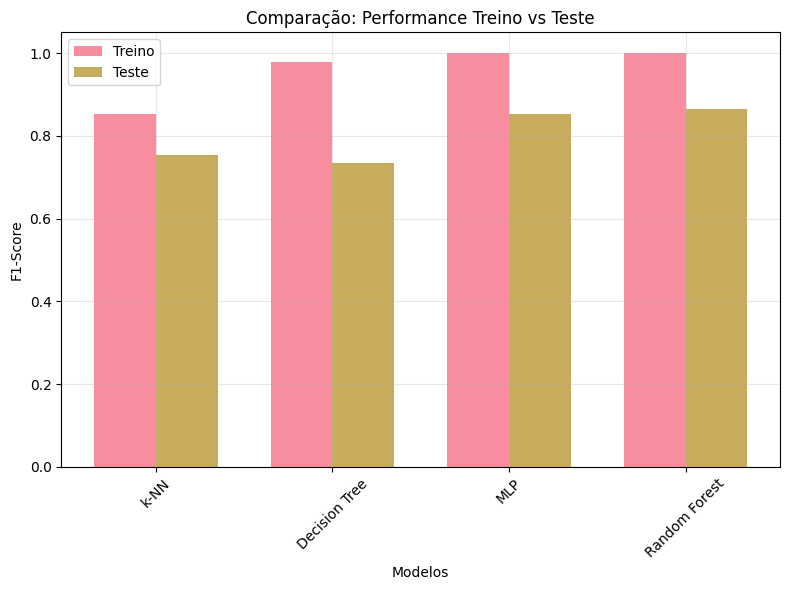

In [28]:
### 6.2 Análise de Overfitting e Generalização

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

print("🔍 ANÁLISE DE OVERFITTING E GENERALIZAÇÃO")
print("="*60)

# Verificar se as variáveis necessárias existem
if 'train_df' not in globals() or 'val_df' not in globals():
    print("⚠️ Erro: As variáveis 'train_df' e 'val_df' não estão definidas.")
    print("Execute as células de carregamento de dados primeiro.")
else:
    # Dados de treino e validação combinados para análise
    X_train_full = pd.concat([train_df.drop('target', axis=1), val_df.drop('target', axis=1)])
    y_train_full = pd.concat([train_df['target'], val_df['target']])

    # Análise para cada modelo
    overfitting_analysis = []

    for model_name, model in best_models.items():
        # Performance no treino
        y_train_pred = model.predict(X_train_full)
        train_f1 = f1_score(y_train_full, y_train_pred, average='weighted')

        # Performance no teste
        y_test_pred = model.predict(X_test)
        test_f1 = f1_score(y_test, y_test_pred, average='weighted')

        overfitting_analysis.append({
            'Modelo': model_name,
            'F1_Treino': train_f1,
            'F1_Teste': test_f1
        })

    # Criar DataFrame para visualização
    overfitting_df = pd.DataFrame(overfitting_analysis)

    # Gráfico comparativo Treino vs Teste
    plt.figure(figsize=(8, 6))
    x = np.arange(len(overfitting_df))
    width = 0.35
    plt.bar(x - width/2, overfitting_df['F1_Treino'], width, label='Treino', alpha=0.8)
    plt.bar(x + width/2, overfitting_df['F1_Teste'], width, label='Teste', alpha=0.8)
    plt.xlabel('Modelos')
    plt.ylabel('F1-Score')
    plt.title('Comparação: Performance Treino vs Teste')
    plt.xticks(x, overfitting_df['Modelo'], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()